In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
import astropy.units as u

from elisa import settings
from elisa.analytics import LCData, LCBinaryAnalyticsTask

print(os.cpu_count())

16


In [2]:
kepler_data = LCData.load_from_file(filename='E:\Coding\PyCharm Python Projects\light curve testing\ELISA_data.dat',
                                    x_unit=None,
                                    y_unit=None
                                   )
# phasing the observations
period = 2.47028  # d
t0 = 54953.900507000006  # d

kepler_data.convert_to_phases(period, t0, centre=0.0)

In [3]:
lc_initial = {
    'system': {
        # setting a reasonable expected starting value and range of the parameters
        'inclination': {
            'value': 76.0,
            'fixed': False,
            'min': 65,
            'max': 90,
            'unit': u.deg
        },
        'eccentricity': {
            'value': 0.02,
            'fixed': False,
            'min': 0.0,
            'max': 0.1,
        },
        # mass ratio is much more acurately determined from RV fit, therefore we will keep it fixed during initial LC fit
        'mass_ratio': {
            'value': 1.08,
            'fixed': True,
        },
        'argument_of_periastron': {
            'value': 233,
            'fixed': False,
            'min': 0,
            'max': 360,
            'unit': u.deg
        },
        # this parameter is constrained to orbital inclination via the `asini` derived during the RV fit
        'semi_major_axis': {
            'constraint': '11.2 / sin(radians(system@inclination))',  # IMPORTANT: only variable model parameters can be used to define a constraint
            'unit': u.solRad
        },
        'period': {
            'value':2.47028,
            'fixed': True,
            'unit': u.d
        },
        # this parameter allows for the presence of the third light
        'additional_light': {
            'value': 0.0,
            'fixed': False,
            'min': 0.0,
            'max': 0.5,
        },
        # accounting for imprecision of the ephemeris
        'phase_shift': {
            'value': 0,
            'fixed': False,
            'min': -0.02,
            'max': 0.02,
        },
        # 'primary_minimum_time': {
        #     'value': 54953.900507000006,
        #     'fixed': True,
        #     'unit': u.d,
        # }, time of primary minimum should be supplied only in case when LCData contain light curves in BJD
        # instad of photometric phase
    },
    'primary': {
        # initial run will keep the primary effective temperature fixed on the value derived in the literature (Armstrong et al. 2013, MNRAS, 437, 4, 3473–3481)
        't_eff': {
            'value': 7022.0,
            'fixed': True,
            'unit': u.K
        },  # fixed to value found in literature
        'surface_potential': {
            'value': 6.1,
            'fixed': False,
            'min': 5.0,
            'max': 10.0,
        },
        # albedos and gravity darkening factors will stay fixed for the initial run
        'albedo': {
            'value': 1.0,
            'fixed': True
        },
        'gravity_darkening': {
            'value': 1.0,
            'fixed': True
        },
        # assuming synchronized rotation at periastron
        "synchronicity": {
            "value": 1.00,
            "constraint": "(1 + system@eccentricity)**2 / (1 - system@eccentricity**2)**(3.0/2.0)",
            "unit": None
        },
        "metallicity": {
            "value": 0.0,
            "fixed": True,
            "unit": None
        }
    },
    'secondary': {
        't_eff': {
            'value': 6804,
            'fixed': False,
            'min': 3500.0,
            'max': 10000.0,
            'unit': u.K
        },
        'surface_potential': {
            'value': 6.2,
            'fixed': False,
            'min': 4.0,
            'max': 10.0,
        },
        'albedo': {
            'value': 1.0,
            'fixed': True
        },
        'gravity_darkening': {
            'value': 1.0,
            'fixed': True
        },
        "synchronicity": {
            "value": 1.00,
            "constraint": "(1 + system@eccentricity)**2 / (1 - system@eccentricity**2)**(3.0/2.0)",
            "unit": None
        },
        "metallicity": {
            "value": 0.0,
            "fixed": True,
            "unit": None
        }
    }
}

2022-11-10 18:22:25,672 - 12268 - observer.observer - INFO: initialising Observer instance
2022-11-10 18:22:25,717 - 12268 - binary_system.system - INFO: initialising object BinarySystem
2022-11-10 18:22:25,745 - 12268 - binary_system.system - INFO: setting discretization factor of secondary component to 8.00 according to discretization factor of the companion.
2022-11-10 18:22:25,746 - 12268 - observer.observer - INFO: observation is running
2022-11-10 18:22:26,806 - 12268 - binary_system.curves.c_router - INFO: one half of the curve points on the one side of the apsidal line will be interpolated
2022-11-10 18:22:31,328 - 12268 - observer.observer - INFO: observation finished


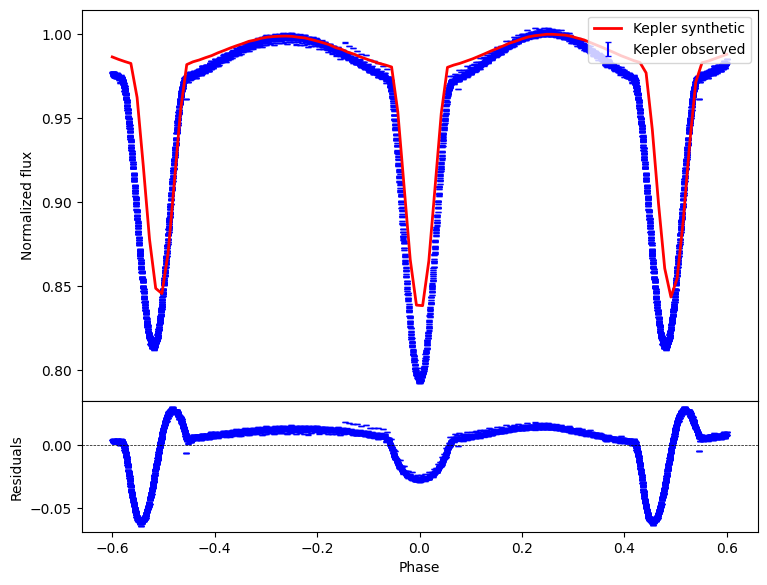

In [4]:
lst_sqr_task = LCBinaryAnalyticsTask(data={'Kepler': kepler_data}, method='least_squares', expected_morphology="detached")

lst_sqr_task.set_result(lc_initial)
# lst_sqr_task.load_result(filename)  # in case that your staring parameters are stored as a json in file

lst_sqr_task.plot.model(discretization=10, number_of_points=100, start_phase=-0.6, stop_phase=0.6)

In [ ]:
settings.configure(NUMBER_OF_PROCESSES=8)

param_file = 'E:\Coding\PyCharm Python Projects\light curve testing\ELISA_tutorial_params.json'

# this part can take a while to complete in case of eccentric orbit
lst_sqr_result = lst_sqr_task.fit(x0=lc_initial, discretization=10, interp_treshold=200, samples='adaptive')
lst_sqr_task.save_result(param_file)

# load pre-calculated results if you don't want to wait
lst_sqr_task.load_result(param_file)
lst_sqr_result = lst_sqr_task.get_result()
lst_sqr_task.fit_summary()

2022-11-10 18:22:32,346 - 12268 - observer.observer - INFO: initialising Observer instance
2022-11-10 18:22:32,352 - 12268 - analytics.binary_fit.shared - INFO: Generating equidistant samples along the light curve using adaptive sampling method
2022-11-10 18:22:32,353 - 12268 - observer.observer - INFO: initialising Observer instance
2022-11-10 18:22:32,355 - 12268 - binary_system.system - INFO: initialising object BinarySystem
2022-11-10 18:22:32,382 - 12268 - binary_system.system - INFO: setting discretization factor of secondary component to 8.00 according to discretization factor of the companion.
2022-11-10 18:22:32,384 - 12268 - observer.observer - INFO: observation is running
2022-11-10 18:22:43,252 - 12268 - binary_system.curves.c_router - INFO: geometry of the stellar surface on one half of the apsidal line will be copied from their closest symmetrical counterparts
2022-11-10 18:22:43,253 - 12268 - observer.mp - INFO: starting multiprocessor workers
2022-11-10 18:22:51,507 - 1